# 🚀 Gemma 3 (270M) + **Unsloth FastModel** on **MIRIAD‑4.4M** (Medical QA)

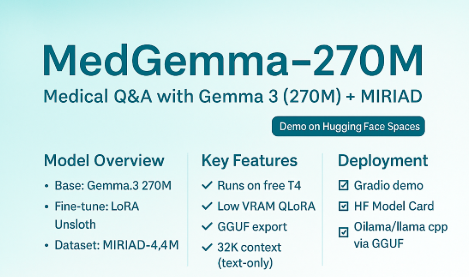



**Author: Syed Omer Shah**

This notebook fine‑tunes **Gemma 3 (270M)** on **MIRIAD‑4.4M** using **Unsloth FastModel** for **faster & lower‑VRAM** training (QLoRA, Unsloth gradient checkpointing, sequence **packing**).  
It includes:
- Chat‑template formatting for supervised fine‑tuning (SFT)  
- **TRL SFTTrainer** (packing=True) for speed & memory savings  
- **Gradio** demo (prints a public URL with `share=True`)  
- **Hub push** — save LoRA **or** save **merged 16‑bit** weights for easy deployment


In [ ]:
%%capture
import os
if "COLAB_" not in "".join(os.environ.keys()):
    !pip install unsloth
else:
    # Do this only in Colab notebooks! Otherwise use pip install unsloth
    !pip install --no-deps bitsandbytes accelerate xformers==0.0.29.post3 peft trl triton cut_cross_entropy unsloth_zoo
    !pip install sentencepiece protobuf "datasets>=3.4.1,<4.0.0" "huggingface_hub>=0.34.0" hf_transfer
    !pip install --no-deps unsloth
    !pip -q install flash-attn --no-build-isolation
import torch
from unsloth import FastModel

In [ ]:

#@title Login to Hugging Face (accept Gemma 3 terms first)
from getpass import getpass
from huggingface_hub import login

hf_token = None  #@param {type:"string"}
if not hf_token:
    try:
        hf_token = 'your_hf_token'
        login(hf_token)
    except Exception:
        hf_token = None

if hf_token:
    login(hf_token)
else:
    print("⚠️ Proceeding without login. You'll need to login to pull/push private models.")


In [ ]:

#@title Configuration
# Text-only 270M model (instruction-tuned is helpful for QA)
base_model_id = "google/gemma-3-270m-it"  #@param ["google/gemma-3-270m-it","google/gemma-3-270m"]
dataset_id = "miriad/miriad-4.4M"         #@param {type:"string"}

# Training subset sizes (scale up if you have more compute)
train_samples = 2_000  #@param {type:"integer"}
eval_samples  = 20    #@param {type:"integer"}

# Sequence & optimizer settings
max_seq_length = 4096     # 270M supports up to 32K; 4K is a good start
learning_rate = 5e-5
num_train_epochs = 1
per_device_train_batch_size = 1
gradient_accumulation_steps = 1
weight_decay = 0.0
logging_steps = 25
save_steps = 10
save_total_limit = 1

# LoRA with Unsloth FastModel
lora_r = 128
lora_alpha = 128
lora_dropout = 0.0
target_modules = ["q_proj","k_proj","v_proj","o_proj","gate_proj","up_proj","down_proj"]

# Output & Hub
output_dir = "gemma3-270m-miriad-unsloth"
push_to_hub = False
hub_model_id = output_dir   # or "<org>/<repo>"


In [ ]:

#@title Load & sample MIRIAD
from datasets import load_dataset

raw = load_dataset(dataset_id, split="train")
raw = raw.shuffle(seed=42)

train_ds = raw.select(range(min(train_samples, len(raw))))
eval_start = min(train_samples + 10_000, len(raw) - eval_samples)
eval_start = max(eval_start, 0)
eval_end = min(eval_start + eval_samples, len(raw))
eval_ds = raw.select(range(eval_start, eval_end))

print("Train/Eval sizes:", len(train_ds), len(eval_ds))
print("Columns:", train_ds.column_names)


Resolving data files:   0%|          | 0/49 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/49 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/49 [00:00<?, ?it/s]

Train/Eval sizes: 2000 20
Columns: ['qa_id', 'paper_id', 'question', 'answer', 'paper_url', 'paper_title', 'passage_text', 'passage_position', 'year', 'venue', 'specialty']


In [ ]:

#@title Convert QA rows -> chat-formatted text via Gemma 3 template
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(base_model_id, use_fast=True)

SYSTEM_PROMPT = (
    "You are a helpful medical assistant for educational and research purposes. "
    "Answer concisely, cite key concepts, and avoid clinical diagnosis or individualized medical advice."
)

def to_text(example):
    q = example["question"]
    a = example["answer"]
    passage = (example.get("passage_text") or "").strip()
    messages = [
        {"role": "system", "content": SYSTEM_PROMPT},
        {"role": "user",   "content": f"Question: {q}\n\n{passage}"},
        {"role": "assistant","content": a},
    ]
    return {"text": tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=False)}

train_texts = train_ds.map(to_text, remove_columns=train_ds.column_names)
eval_texts  = eval_ds.map(to_text,  remove_columns=eval_ds.column_names)

print(train_texts[0]["text"][:800])


Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/20 [00:00<?, ? examples/s]

<bos><start_of_turn>user
You are a helpful medical assistant for educational and research purposes. Answer concisely, cite key concepts, and avoid clinical diagnosis or individualized medical advice.

Question: What are the indications for palliative radiotherapy in the treatment of metastatic breast cancer?

Patients' preferences should always be taken into account. Co-ordination and continuity of care may need to be facilitated by a specialist breast care nurse or key worker. Systemic treatment options for MBC are endocrine therapy, chemotherapy and biological agents such as trastuzumab, bevacizumab and lapatinib [I, A] (see Table 1 ). The choice of therapy should be made after consideration of factors such as: previous therapies and response to them, disease-free interval, endocrine res


In [ ]:

#@title Load model with **Unsloth FastModel** + QLoRA (4-bit) + gradient checkpointing

compute_capability = torch.cuda.get_device_capability()[0] if torch.cuda.is_available() else 0
torch_dtype = torch.bfloat16 if compute_capability >= 8 else torch.float16

# Load in 4-bit for minimal VRAM
model, tokenizer = FastModel.from_pretrained(
    base_model_id,
    max_seq_length=max_seq_length,
    load_in_4bit=True,
    dtype=torch_dtype,
)

# Attach LoRA adapters with Unsloth's optimized gradient checkpointing
model = FastModel.get_peft_model(
    model,
    r=lora_r,
    target_modules=target_modules,
    lora_alpha=lora_alpha,
    lora_dropout=lora_dropout,
    bias="none",
    use_gradient_checkpointing="unsloth",  # memory saving
    use_rslora=False,
    loftq_config=None,
)

print("Loaded:", base_model_id, "dtype:", torch_dtype)


==((====))==  Unsloth 2025.8.5: Fast Gemma3 patching. Transformers: 4.55.0.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 7.5. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.29.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
Unsloth: Using float16 precision for gemma3 won't work! Using float32.
Unsloth: Making `model.base_model.model.model` require gradients
Loaded: google/gemma-3-270m-it dtype: torch.float16


In [ ]:

#@title Train with TRL SFTTrainer (packing=True to save memory)
from trl import SFTTrainer, SFTConfig

sft_config = SFTConfig(
    output_dir=output_dir,
    per_device_train_batch_size=per_device_train_batch_size,
    gradient_accumulation_steps=gradient_accumulation_steps,
    num_train_epochs=num_train_epochs,
    learning_rate=learning_rate,
    # max_seq_length=max_seq_length,
    weight_decay=weight_decay,
    logging_steps=logging_steps,
    save_steps=save_steps,
    save_total_limit=save_total_limit,
    fp16=(torch_dtype==torch.float32),
    bf16=(torch_dtype==torch.bfloat16),
    # packing=True,                 # <-- enables sequence packing for speed & VRAM
    dataset_text_field="text",
    report_to=["tensorboard"],
    push_to_hub=push_to_hub,
    hub_model_id=hub_model_id if push_to_hub else None,
    dataset_num_proc=1,
    # attn_implementation='flash_attention_2'
)

trainer = SFTTrainer(
    model=model,
    tokenizer=tokenizer,
    args=sft_config,
    train_dataset=train_texts,
    eval_dataset=eval_texts,
)

trainer.train()
trainer.save_model(output_dir)        # saves LoRA adapters
tokenizer.save_pretrained(output_dir)
print("Saved LoRA to", output_dir)


Unsloth: Switching to float32 training since model cannot work with float16


Unsloth: Tokenizing ["text"]:   0%|          | 0/2000 [00:00<?, ? examples/s]

Unsloth: Tokenizing ["text"]:   0%|          | 0/20 [00:00<?, ? examples/s]

Step,Training Loss
25,3.541600
50,3.262900
75,3.508900
100,3.655900
125,3.633200
150,3.755100
175,3.751100
200,3.649700
225,3.658600
250,3.797200


Saved LoRA to gemma3-270m-miriad-unsloth


In [ ]:

#@title (Optional) Save **merged 16-bit** weights for easy deployment
MERGED_DIR = output_dir + "-merged-16bit"

try:
    model.save_pretrained_merged(MERGED_DIR, tokenizer, save_method="merged_16bit")
    print("✅ Merged 16-bit model saved to", MERGED_DIR)
except Exception as e:
    print("Merging failed:", e)


Found HuggingFace hub cache directory: /root/.cache/huggingface/hub
Checking cache directory for required files...
Successfully copied all 1 files from cache to gemma3-270m-miriad-unsloth-merged-16bit.


Unsloth: Merging weights into 16bit:   0%|          | 0/1 [00:45<?, ?it/s]


KeyboardInterrupt: 

In [ ]:

#@title Inference helper (uses current trainer.model with LoRA)
def chat(question, passage=None, max_new_tokens=256, temperature=0.2):
    messages = [
        {"role": "system", "content": "Educational use only. Not medical advice."},
        {"role": "user", "content": f"Question: {question}\n\n{(passage or '').strip()}"},
    ]
    prompt = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
    inputs = tokenizer([prompt], return_tensors="pt").to(model.device)
    with torch.inference_mode():
        out = model.generate(**inputs, max_new_tokens=max_new_tokens, do_sample=True, top_p=1.0, temperature=temperature, eos_token_id=tokenizer.eos_token_id)
    return tokenizer.batch_decode(out[:, inputs.input_ids.shape[-1]:], skip_special_tokens=True)[0].strip()

print(chat("What are common causes of elevated troponin besides myocardial infarction?")[:400])


Convert LORA Files to GGUF

In [ ]:
MODEL_ID      = "OmerShah/MedGemma"      # your model repo
GGUF_QUANT    = "q4_k_m"                 # options: q2_k, q4_k_m, q5_k_m, q8_0, or None (unquantized)
OUTFILE_NAME  = "MedGemma-270M.gguf"     # output filename

# (Optional) Push GGUF back to the Hub
PUSH_TO_HUB   = False                    # set True to auto-push
GGUF_REPO_ID  = "OmerShah/MedGemma-GGUF" # change if you like; created if missing
HF_TOKEN      = None                     # paste a token if your account/repos are private

# --- installs ---
!apt-get -qq install -y git-lfs >/dev/null
!git clone -q https://github.com/ggerganov/llama.cpp
!pip -q install -r /content/llama.cpp/requirements.txt
!pip -q install "huggingface_hub>=0.24.5"

# --- download the HF model snapshot ---
from huggingface_hub import snapshot_download, login
import os, sys, pathlib, shutil
from pathlib import Path

if HF_TOKEN:
    try:
        login(HF_TOKEN)
        print("✅ Logged in to Hugging Face")
    except Exception as e:
        print("HF login failed/ignored:", e)

local_dir = "/content/hf_model"
if Path(local_dir).exists():
    shutil.rmtree(local_dir)
Path(local_dir).mkdir(parents=True, exist_ok=True)

print(f"⬇️  Downloading {MODEL_ID} ...")
snapshot_download(
    repo_id=MODEL_ID,
    local_dir=local_dir,
    local_dir_use_symlinks=False,
)
print("✅ Model ready at", local_dir)

# --- convert HF -> GGUF ---
outfile = f"/content/{OUTFILE_NAME}"
cmd = [
    sys.executable, "/content/llama.cpp/convert-hf-to-gguf.py",
    "--model-dir", local_dir,
    "--outfile", outfile,
]
if GGUF_QUANT:
    cmd += ["--quantize", GGUF_QUANT]

print("🔁 Converting to GGUF …")
print(" ".join(cmd))
rc = os.system(" ".join(cmd))
if rc != 0:
    raise RuntimeError("GGUF conversion failed (try updating llama.cpp to latest).")

print("✅ GGUF written at:", outfile)
!ls -lh {outfile}

# --- download (Colab) ---
try:
    from google.colab import files
    files.download(outfile)
    print("⬇️ Download prompt sent.")
except:
    print("Not in Colab; file is at:", outfile)

# --- optional: push GGUF back to the Hub ---
if PUSH_TO_HUB:
    from huggingface_hub import HfApi
    api = HfApi()
    api.create_repo(GGUF_REPO_ID, repo_type="model", private=False, exist_ok=True)
    repo_dir = "/content/gguf_repo"
    if Path(repo_dir).exists():
        shutil.rmtree(repo_dir)
    !git lfs install
    !git clone https://huggingface.co/{GGUF_REPO_ID} {repo_dir}
    !cp {outfile} {repo_dir}/
    %cd {repo_dir}
    !git add .
    !git commit -m "Add GGUF export of OmerShah/MedGemma ({GGUF_QUANT or 'f16'})"
    !git push
    %cd /content
    print(f"🚀 Pushed to https://huggingface.co/{GGUF_REPO_ID}")

In [ ]:

#@title Gradio demo (prints a public URL)
import gradio as gr

def gr_answer(question, passage):
    return chat(question, passage)

demo = gr.Interface(
    fn=gr_answer,
    inputs=[gr.Textbox(label="Medical question"),
            gr.Textbox(label="Optional background passage", lines=6)],
    outputs=gr.Textbox(label="Answer"),
    title="Gemma 3 (270M) — Medical QA (MIRIAD)",
    description="Educational use only. Not medical advice.",
)
demo.launch(share=True)
